##### Metody obliczeniowe w nauce i technice

## Laboratorium 6 - Równania liniowe

### Sprawozdanie sporządził: Marcin Zielonka

### Wstęp

Do realizacji zadań skorzystam z gotowych funkcjonalności zawartych w bibliotekach:
* `numpy`
* `matplotlib`
* `networkx`
* `time`
* `random`

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import time
import random

Na potrzeby wszystkich zadań, zdefiniowałem margines błędu przy porównywaniu wartości

In [21]:
err = 1e-12

### Zadanie 1: Metoda Gaussa-Jordana

Napisz i sprawdź funkcję rozwiązującą układ równań liniowych $n×n$ metodą Gaussa-Jordana. Dla rozmiarów macierzy współczynników większych niż $500$ × $500$ porównaj czasy działania zaimplementowanej funkcji z czasami uzyskanymi dla wybranych funkcji bibliotecznych.

Implementacji funkcji realizującej rozwiązywanie układu równań metodą Gausa-Jordana z częściowym pivotingiem:

In [3]:
def gauss_jordan(A, B):
    n = len(B)
    
    for i in range(n):
        for j in range(i + 1, n):
            if abs(A[j][i]) > abs(A[i][i]):
                A[[i, j]] = A[[j, i]]
                B[i], B[j] = B[j], B[i]
        
        for j in range(i + 1, n):
            m = A[j][i] / A[i][i]
            A[j] = A[j] - m * A[i]
            B[j] = B[j] - m * B[i]
    
    for i in range(n):
        m = A[i][i]
        A[i] = A[i] / m
        B[i] = B[i] / m
    
    for i in range(n):
        B[n - i - 1] = B[n - i - 1] - np.sum((A[n - i - 1] * B)[(n - i):])
    
    return B

Funkcja sprawdzająca, czy implementacja metody jest poprawna (porównanie do działania funkcji bibliotecznej `numpy.linalg.solve`):

In [4]:
def check_results(n, epsilon):
    attempts = n
    fail = 0
    success = 0
    
    N = np.random.randint(5, high=100, size=n)
    
    for n in N:
        A = np.random.randint(low=-100, high=100, size=(20, 20)).astype(float)
        B = np.random.randint(low=1, high=100, size=20).astype(float)
        
        S1 = np.linalg.solve(A, B)
        S2 = gauss_jordan(A, B)
        
        if np.array(list(map(lambda x: abs(x) <= epsilon, (S2 - S1)))).all():
            success += 1
        else:
            fail += 1
    
    return attempts, fail, success

Przedstawienie wyników w postaci wykresu ze względu na dopuszczalny margines błędu dla wyników poszczególnych funkcji (od $1$ do $10^{-20})$.

Niebieska linia oznacza wszystkie próby, zielone punkty oznaczają ilość prób zakończonych sukcesem, a czerwone - ilość prób zakończonych błędem.

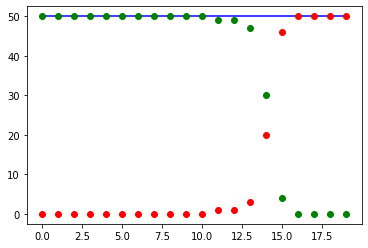

In [5]:
n = 50

alls = []
successes = []
fails = []

for i in range(20):
    epsilon = 10 ** (- i)
    
    attempts, fail, success = check_results(n, epsilon)
    
    alls.append(attempts)
    successes.append(success)
    fails.append(fail)

plt.plot(alls, 'b')
plt.plot(fails, 'ro')
plt.plot(successes, 'go')

plt.show()
    

Jak widać, przy dopuszczalnym błędu rzędu $10^{-14}$ obie funkcje dają różne wyniki. Jednakże ze względu na tak mały margines błędy, można takowy błąd ominąć przy korzystaniu z zaimplementowanej funkcji.

Porównanie czasów działania obu funkcji:

In [6]:
def elapsed_time(A, B):
    linalg_start = time.time()
    np.linalg.solve(A, B)
    linalg_end = time.time()
    
    gauss_start = time.time()
    gauss_jordan(A, B)
    gauss_end = time.time()
    
    return (linalg_end - linalg_start), (gauss_end - gauss_start)

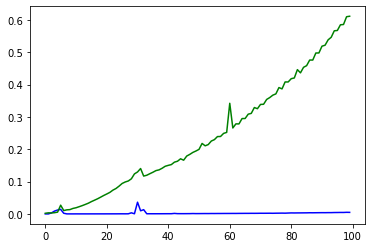

In [7]:
times_linalg = []
times_gauss = []

for n in np.linspace(10, 500, num=100, dtype=int):
    A = np.random.randint(1, high=50, size=(n, n)).astype(float)
    B = np.random.randint(1, high=50, size=n).astype(float)
    
    time_linalg, time_gauss = elapsed_time(A, B)
    times_linalg.append(time_linalg)
    times_gauss.append(time_gauss)

plt.plot(times_linalg, 'b')
plt.plot(times_gauss, 'g')

plt.show()
    

Jak widać, funkcja biblioteczna działa o wiele szybciej - w szczególności jest to widoczne dla większych rozmiarów układu równań (rzędu $n$ = 400-500). Jest to spowodowane najprawdopodobniej lepszą optymalizacją algorytmu wyliczającego układ równań.

### Zadanie 2: Faktoryzacja LU

Napisz i sprawdź funkcję dokonującą faktoryzacji $\mathbf{A}=\mathbf{LU}$ macierzy $\mathbf{A}$. Zastosuj częściowe poszukiwanie elementu wiodącego oraz skalowanie.

In [8]:
def lu_solve(A):
    n = len(A)
    
    L = np.array([[0] * n] * n).astype(float)
    U = np.array([[0] * n] * n).astype(float)
    
    for i in range(n):
        L[i][i] = 1
    
    for j in range(n):
        for i in range(n):
            if i <= j:
                U[i][j] = A[i][j] - np.sum(L[i,0:i] * U[0:i,j])
            else:
                L[i][j] = 1 / U[j][j] * (A[i][j] - np.sum(L[i, 0:j] * U[0:j, j]))
    
    return L, U

Przedstawienie wyników w postaci wykresu ze względu na dopuszczalny margines błędu dla wyników poszczególnych funkcji (od $1$ do $10^{-20})$.

Niebieska linia oznacza wszystkie próby, zielone punkty oznaczają ilość prób zakończonych sukcesem, a czerwone - ilość prób zakończonych błędem.

In [9]:
def check_results(n, epsilon):
    attempts = n
    fail = 0
    success = 0
    
    N = np.random.randint(5, high=100, size=n)
    
    for n in N:
        A = np.random.randint(low=-100, high=100, size=(20, 20)).astype(float)
        
        L, U = lu_solve(A)
        S = np.dot(L, U)
        
        if np.array(list(map(lambda x: abs(x) <= epsilon, (A.flatten() - S.flatten())))).all():
            success += 1
        else:
            fail += 1
    
    return attempts, fail, success

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


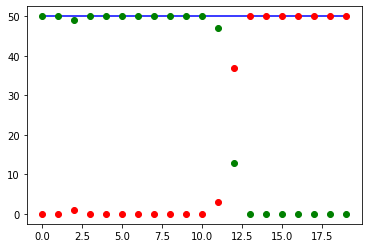

In [10]:
n = 50

alls = []
successes = []
fails = []

for i in range(20):
    epsilon = 10 ** (- i)
    
    attempts, fail, success = check_results(n, epsilon)
    
    alls.append(attempts)
    successes.append(success)
    fails.append(fail)

plt.plot(alls, 'b')
plt.plot(fails, 'ro')
plt.plot(successes, 'go')

plt.show()

Jak widać, przy dopuszczalnym błędu rzędu $10^{-12}$ obie funkcje dają różne wyniki. Jednakże ze względu na tak mały margines błędy, można takowy błąd ominąć przy korzystaniu z zaimplementowanej funkcji.

### Zadanie 3: Analiza obwodu elektrycznego

Napisz program, który:

1. Wczytuje z pliku listę krawędzi grafu opisującego obwód elektryczny. Wagi krawędzi określają opór fragmentu obwodu między dwoma węzłami. Wierzchołki grafu identyfikowane są przez liczby naturalne.

In [22]:
def read_graph(filename):
    G = nx.Graph()
    
    file = open(filename, 'r')
    for idx, line in enumerate(list(file)):
        data = line.split()
        
        u = int(data[0])
        v = int(data[1])
        R = int(data[2])
        
        G.add_edge(u, v, R=R, E=0, idx=idx)
        
    return G

In [23]:
G = read_graph('graph-1.txt')

2. Wczytuje dodatkowo trójkę liczb (s, t, E), przy czym para (s, t) wskazuje między którymi węzłami sieci przyłożono siłę elektromotoryczną E. Opór wewnętrzny SEM można zaniedbać.

In [24]:
def attach_voltage(G, s, t, E):
    G[s][t]['E'] = E

In [25]:
def attach_current(G, I):
    for n1, n2 in G.edges():
        idx = G[n1][n2]['idx']
        G[n1][n2]['I'] = I[idx]

3. Wykorzystując prawa Kirchhoffa znajduje natężenia prądu w każdej części obwodu i przedstawia je na rysunku w postaci grafu ważonego z etykietami.

In [26]:
def show_graph(G, attribute, pos=nx.kamada_kawai_layout(G)):
    nx.draw_networkx_edge_labels(
        G, 
        pos=pos, 
        edge_labels=nx.get_edge_attributes(G, attribute)
    )
    
    nx.draw(
        G, 
        pos=pos,
        node_size=150,
        font_size=8,
        with_labels=True
    )

In [27]:
def solve_kirchoff(G):
    n = nx.number_of_edges(G)
    
    IR = np.array([[0] * n] * (n + 1)).astype(float)
    EI = np.array([0] * (n + 1)).astype(float)
    
    current_equation = 0
    
    cycles = nx.cycle_basis(G)
    
    # add equations based on cycles (II Kirchoff's Law)
    for cycle in cycles:
        cycle_length = len(cycle)
        
        for j in range(cycle_length):
            u = cycle[j]
            v = cycle[(j + 1) % cycle_length]
            
            idx = G[u][v]['idx']
            R = G[u][v]['R']
            E = G[u][v]['E']
            direction = -1 if u <= v else 1
            
            IR[current_equation][idx] = direction * R
            EI[current_equation] = -direction * E
            
        current_equation += 1
    
    # add additional equations based on nodes (I Kirchoff's Law) - if no sufficient amount of equations
    for node in G.nodes():
        if current_equation < n:
            for n1, n2 in G.edges(node):
                idx = G[n1][n2]['idx']
                IR[current_equation][idx] = 1 if n2 <= n1 else -1
            current_equation += 1
    
    # check if is proper amount of equations
    if current_equation == n:
        IR2 = np.delete(IR, n, 0)
        EI2 = np.delete(EI, n)
        
        if abs(np.linalg.det(IR2)) > err:
            return np.linalg.solve(IR2, EI2)
        else:
            raise Exception("Error - Cannot solve equation")
    
    # if there are more equations (from cycles)
    # every time remove another equation and check if can be solved (as one equation is unnecessary)
    for i in range(current_equation):
        IR2 = np.delete(IR, i, 0)
        EI2 = np.delete(EI, i)
            
        if abs(np.linalg.det(IR2)) > err:
            return np.linalg.solve(IR2, EI2)
        
    # if cannot solve equation - raise exception
    raise Exception("Cannot solve equation")

In [28]:
def check_results(G):
    for cycle in nx.cycle_basis(G):
        E_sum = 0
        
        # check every cycle if sum of voltages is equal 0
        cycle_length = len(cycle)
        for j in range(cycle_length):
            u = cycle[j]
            v = cycle[(j + 1) % cycle_length]
            direction = -1 if u <= v else 1
            
            U = direction * G[u][v]['I'] * G[u][v]['R']
            E = direction * G[u][v]['E']
            
            E_sum += (U + E)
        
        print(f'Voltage sum for cycle: {E_sum}')
        
        if E_sum > err:
            return False
    
    return True

4. Wykorzystując metodę potencjałów węzłowych zaimplementuj alternatywne rozwiązanie problemu.

5. Przedstaw (wizualizacja + sprawdzenie poprawności wyników) działanie programu dla grafów spójnych mających od 15 do 100 wierzchołków:
    * Spójny graf losowy
    * Graf 3-regularny (kubiczny)
    * Graf złożony z dwóch grafów losowych połączonych mostkiem
    * Graf siatka 2D

**Spójny graf losowy:**

Wygenerowanie struktury grafu:

In [29]:
G = nx.Graph()
n = 20

idx = 0
for u in range(1, n + 1):
    for v in range(1, n + 1):
        if u < v:
            G.add_edge(u, v, R=10, E=0, idx=idx)
            idx += 1

attach_voltage(G, 1, 2, 100)

Wizualizacja grafu: (ze względu na dużą ilość krawędzi, wyświetlenie etykiet spowodowałoby nieczytelność wizualizacji)

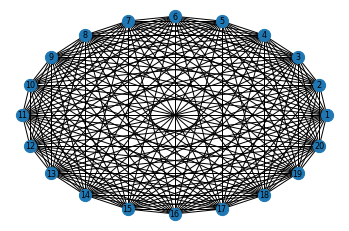

In [30]:
show_graph(G, '', pos=nx.circular_layout(G))

Obliczenie natężeń na danych opornikach:

In [31]:
I = solve_kirchoff(G)
print(I)

[-9.00000000e+00  5.00000000e-01  5.00000000e-01  5.00000000e-01
  5.00000000e-01  5.00000000e-01  5.00000000e-01  5.00000000e-01
  5.00000000e-01  5.00000000e-01  5.00000000e-01  5.00000000e-01
  5.00000000e-01  5.00000000e-01  5.00000000e-01  5.00000000e-01
  5.00000000e-01  5.00000000e-01  5.00000000e-01 -5.00000000e-01
 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01
 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01
 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01
 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01 -5.00000000e-01
 -5.00000000e-01 -0.00000000e+00  4.93038066e-33 -4.93038066e-33
 -9.86076132e-33 -5.55111512e-18 -5.55111512e-18 -5.55111512e-18
 -5.55111512e-18 -5.55111512e-18 -5.55111512e-18 -5.55111512e-18
 -5.55111512e-18 -5.55111512e-18 -5.55111512e-18 -5.55111512e-18
 -5.55111512e-18 -3.33066907e-17  4.93038066e-33 -4.93038066e-33
 -9.86076132e-33 -5.55111512e-18 -5.55111512e-18 -5.55111512e-18
 -5.55111512e-18 -5.55111

In [32]:
attach_current(G, I)

Sprawdzenie otrzymanych wyników poprzez obliczenie, czy dla każdego oczka w obwodzie suma spadków napięć jest równa 0

In [33]:
check_results(G)

Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
V

True

**Graf 3-regularny (kubiczny):**

Wygenerowanie struktury grafu:

In [34]:
G = read_graph('graph-1.txt')
attach_voltage(G, 1, 2, 100)

Wizualizacja grafu:

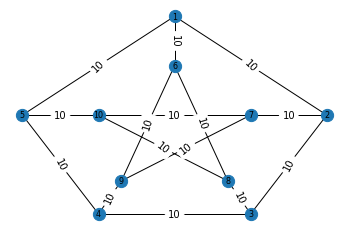

In [35]:
pos = {1:[0,6], 2:[4,0], 3:[2,-6],4:[-2,-6], 5:[-4,0], 6:[0,3], 7:[2,0], 8:[1.4,-4], 9:[-1.4,-4],10:[-2,0]} 
show_graph(G, 'R', pos)

Obliczenie natężeń na danych opornikach:

In [41]:
I = solve_kirchoff(G)
print(I)

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0.]


In [42]:
attach_current(G, I)

Sprawdzenie otrzymanych wyników poprzez obliczenie, czy dla każdego oczka w obwodzie suma spadków napięć jest równa 0

In [44]:
check_results(G)

Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0


True

**Graf złożony z dwóch grafów losowych połączonych mostkiem**

Wygenerowanie struktury grafu:

In [45]:
G = nx.Graph()

n = 10
m = 6

idx = 0
for u in range(1, n + 1):
    for v in range(1, n + 1):    
        if u < v and random.random() < 0.8:
            G.add_edge(u, v, R=10, E=0, idx=idx)
            idx += 1

for u in range(n + 1, n + m + 1):
    for v in range(n + 1, n + m + 1):
        if u < v and random.random() < 0.4:
            G.add_edge(u, v, R=10, E=0, idx=idx)
            idx += 1
            
G.add_edge(n + 1, m + 1, R=10, E=0, idx=idx)
attach_voltage(G, n + 1, m + 1, 100)

Wizualizacja grafu:

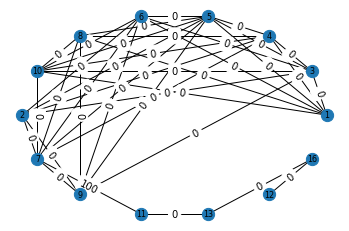

In [46]:
show_graph(G, 'E', pos=nx.circular_layout(G))

Obliczenie natężeń na danych opornikach:

In [47]:
I = solve_kirchoff(G)
print(I)

[-0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0. -0.
 -0. -0.]


In [48]:
attach_current(G, I)

Sprawdzenie otrzymanych wyników poprzez obliczenie, czy dla każdego oczka w obwodzie suma spadków napięć jest równa 0

In [49]:
check_results(G)

Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0


True

**Graf siatka 2D:**

Stworzenie struktury grafu:

In [50]:
G = read_graph('graph-2.txt')
attach_voltage(G, 1, 2, 10)

Wizualizacja grafu:

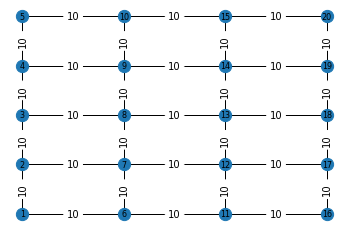

In [51]:
pos = {(5 * u + v + 1): [u, v] for u in range(4) for v in range(5)}
show_graph(G, 'R', pos=pos)

Obliczenie natężeń na danych opornikach:

In [52]:
I = solve_kirchoff(G)
print(I)

[-0.29995645 -0.10047702 -0.03652682 -0.01246352  0.20060767  0.03505221
  0.00336008 -0.00086375  0.06733491  0.03671812  0.01577868  0.00564844
  0.03201387  0.02870668  0.01738807  0.00767884  0.29995645 -0.19947943
 -0.0639502  -0.0240633  -0.01246352  0.09934878 -0.03392397 -0.03225806
 -0.01983947 -0.01332728  0.03201387 -0.00330718 -0.01131862 -0.00970923
 -0.00767884]


In [53]:
attach_current(G, I)

Sprawdzenie otrzymanych wyników poprzez obliczenie, czy dla każdego oczka w obwodzie suma spadków napięć jest równa 0

In [54]:
check_results(G)

Voltage sum for cycle: 0.0
Voltage sum for cycle: -1.3877787807814457e-17
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: 8.326672684688674e-17
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0
Voltage sum for cycle: -5.551115123125783e-17
Voltage sum for cycle: -2.7755575615628914e-17
Voltage sum for cycle: -5.551115123125783e-17
Voltage sum for cycle: 0.0
Voltage sum for cycle: 0.0


True